# Практический проект по предсказанию рейтинга фильма

Извлечение признаков из текста для построения моделей. Работа с методом `tf-idf.`

[Датасет](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) с данными по отзывам с сайта IMDB.

In [1]:
import numpy as np
import pandas as pd
import re
import time
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import nltk
from nltk.stem.snowball import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.linear_model import LogisticRegressionCV

plt.rcParams['figure.figsize'] = 12, 6

In [2]:
df = pd.read_csv('IMDB Dataset.csv')

In [3]:
print(f'Размер выборки: {df.shape}')
df.head()

Размер выборки: (50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Целевая переменная

positive    25000
negative    25000
Name: sentiment, dtype: int64


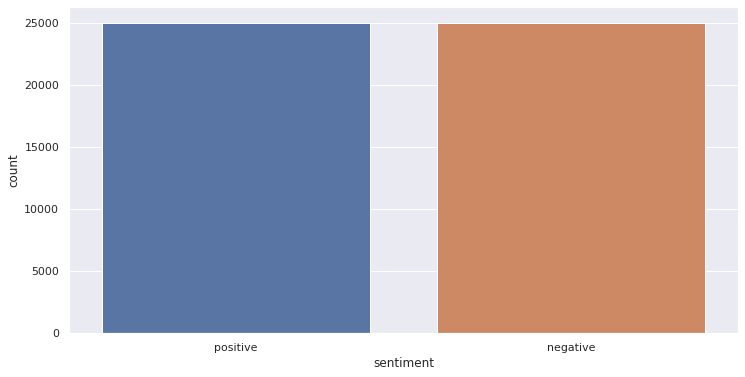

In [4]:
print(df.sentiment.value_counts())
sns.countplot(df.sentiment);

### Закодируем целевую переменную

In [5]:
def sentiment_to_boolean(sentiment):
    return 1 if sentiment == 'positive' else 0

In [6]:
df['sentiment'] = df['sentiment'].apply(sentiment_to_boolean)

### Удалим из текста теги и знаки препинания

In [7]:
def remove_html_tags(doc: str):
    return re.sub('<.*?>', '', doc)

def remove_punctuation(doc: str):
    for i in string.punctuation:
        doc = doc.replace(i, '')
    return doc

In [8]:
df['review'] = df['review'].apply(remove_html_tags)
df['review'] = df['review'].apply(remove_punctuation)

### Лемматизация

In [9]:
def lemmatize(doc: str):
    lemmatizer = WordNetLemmatizer()
    return ' '.join(lemmatizer.lemmatize(i, pos='v') for i in doc.lower().split())

In [10]:
start_time = time.monotonic()
df['review'] = df['review'].apply(lemmatize)
print(f'[*] Done in {time.monotonic() - start_time:.2f} sec.')

[*] Done in 37.43 sec.


In [11]:
df.loc[1000, 'review']

'this movie be awful i cant even be bother to write a review on this garbage all i will say it be one of the most bore film ive ever seenand the act be very bad the boy who play the main character really annoy me hes get the same expression on his face through out the movie i just want to slap him basically 80 of the movie be slow motion shots of skateboarders weird music and utter shtapparently ive get to write at least 10 line of text to submit this comment so ill use up a few more line by say the lead character have get one of those face you just want to slapmeh i give upthis movie suck'

### Разделим на обучающую и тестовую выборки

In [12]:
X = df['review']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

### TF-IDF
И выкинем стоп-слова:

In [13]:
stop_words = stopwords.words('english')

In [14]:
vectorizer = TfidfVectorizer(stop_words=stop_words, norm=None, )
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

### ML

In [15]:
model = LogisticRegressionCV(n_jobs=-1)
start_time = time.monotonic()
model.fit(X_train, y_train)
print(f'[*] Done in {time.monotonic() - start_time:.2f} sec.')

[*] Done in 77.98 sec.


In [16]:
predict = model.predict(X_test)

### Поглядим на метрики

In [17]:
def print_metrics(y_true, y_pred):
    print('====Metrics====')
    names = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC']
    metrics = [accuracy_score, precision_score, recall_score, f1_score, roc_auc_score]
    for name, metric in zip(names, metrics):
        print(f'{name:10s}{metric(y_true, y_pred):.3f}')
    print('===============')

In [18]:
print_metrics(y_test, predict)

====Metrics====
Accuracy  0.895
Precision 0.886
Recall    0.907
F1        0.897
ROC-AUC   0.895


### Визуализация коэффициентов регрессии

In [19]:
feature_names = vectorizer.get_feature_names()
coef = model.coef_[0]
df_feature_importances = pd.DataFrame(
    {'feature': feature_names,
    'importances': coef}
)
df_feature_importances.set_index('feature', inplace=True)
df_feature_importances.sort_values('importances', ascending=False, inplace=True)

Наиболее характерные слова для положительных отзывов:

great
excellent
perfect
favorite
wonderful
best
love
amaze
enjoy
hilarious


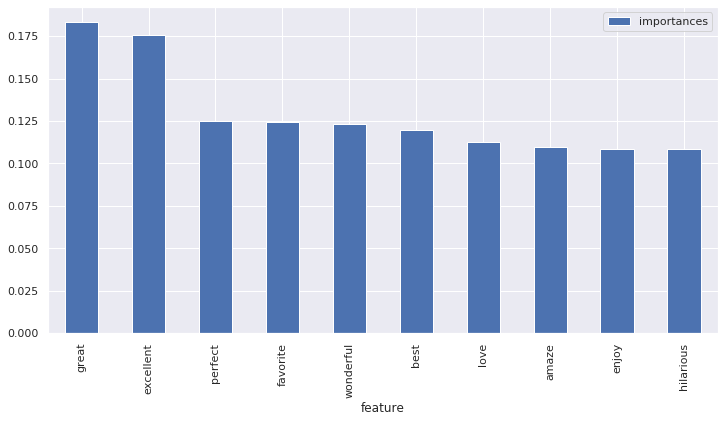

In [20]:
print('Наиболее характерные слова для положительных отзывов:\n')
print('\n'.join(df_feature_importances.iloc[:10, :10].index))
df_feature_importances.iloc[:10, :10].plot.bar();

Наиболее характерные слова для отрицательных отзывов:

worst
waste
awful
bad
bore
poor
terrible
worse
horrible
nothing


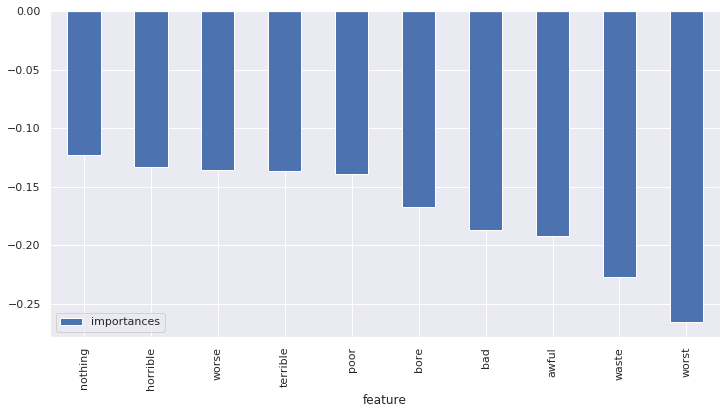

In [21]:
print('Наиболее характерные слова для отрицательных отзывов:\n')
print('\n'.join(df_feature_importances.iloc[-10:, -10:].index[::-1]))
df_feature_importances.iloc[-10:, -10:].plot.bar();